In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-3:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 128)    0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 128)    0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8789 - acc: 0.4103
Epoch 00001: val_loss improved from inf to 1.49863, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_3_conv_checkpoint/001-1.4986.hdf5
36805/36805 [==============================] - 77s 2ms/sample - loss: 1.8788 - acc: 0.4104 - val_loss: 1.4986 - val_acc: 0.5358
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2594 - acc: 0.6084
Epoch 00002: val_loss improved from 1.49863 to 1.36500, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_3_conv_checkpoint/002-1.3650.hdf5
36805/36805 [==============================] - 76s 2ms/sample - loss: 1.2594 - acc: 0.6084 - val_loss: 1.3650 - val_acc: 0.5744
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0113 - acc: 0.6905
Epoch 00003: val_loss improved from 1.3

36800/36805 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9872
Epoch 00028: val_loss did not improve from 1.25326
36805/36805 [==============================] - 76s 2ms/sample - loss: 0.0581 - acc: 0.9872 - val_loss: 2.0624 - val_acc: 0.6569
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9892
Epoch 00029: val_loss did not improve from 1.25326
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0503 - acc: 0.9892 - val_loss: 2.0771 - val_acc: 0.6536
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9933
Epoch 00030: val_loss did not improve from 1.25326
36805/36805 [==============================] - 75s 2ms/sample - loss: 0.0408 - acc: 0.9933 - val_loss: 2.0524 - val_acc: 0.6632
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9906
Epoch 00031: val_loss did not improve from 1.25326
36805/36805 [========================

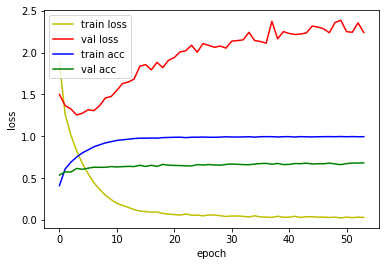

4815/4815 [==============================] - 4s 784us/sample - loss: 1.3458 - acc: 0.5842
Loss: 1.3458196849714064 Accuracy: 0.584216

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8265 - acc: 0.4212
Epoch 00001: val_loss improved from inf to 1.45392, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_4_conv_checkpoint/001-1.4539.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.8265 - acc: 0.4212 - val_loss: 1.4539 - val_acc: 0.5579
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2528 - acc: 0.6160
Epoch 00002: val_loss improved from 1.45392 to 1.26454, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_4_conv_checkpoint/002-1.2645.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 1.2527 - acc: 0.6160 - val_loss: 1.2645 - val_acc: 0.5980
Epoch 3/500
36800/36805 [=======================

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9852
Epoch 00028: val_loss did not improve from 1.02259
36805/36805 [==============================] - 67s 2ms/sample - loss: 0.0541 - acc: 0.9852 - val_loss: 1.5635 - val_acc: 0.7379
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0481 - acc: 0.9876
Epoch 00029: val_loss did not improve from 1.02259
36805/36805 [==============================] - 67s 2ms/sample - loss: 0.0481 - acc: 0.9876 - val_loss: 1.5393 - val_acc: 0.7370
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9873
Epoch 00030: val_loss did not improve from 1.02259
36805/36805 [==============================] - 67s 2ms/sample - loss: 0.0487 - acc: 0.9873 - val_loss: 1.5341 - val_acc: 0.7440
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0401 - acc: 0.9900
Epoch 00031: val_loss did not improve from 1.02259
36805/36805 [===========

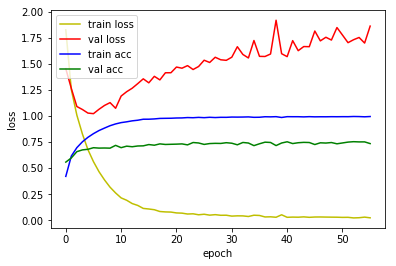

4815/4815 [==============================] - 4s 748us/sample - loss: 1.1330 - acc: 0.6584
Loss: 1.1330423045628786 Accuracy: 0.6583593

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8210 - acc: 0.4230
Epoch 00001: val_loss improved from inf to 1.47760, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_5_conv_checkpoint/001-1.4776.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 1.8208 - acc: 0.4231 - val_loss: 1.4776 - val_acc: 0.5239
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2266 - acc: 0.6243
Epoch 00002: val_loss improved from 1.47760 to 1.08612, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_5_conv_checkpoint/002-1.0861.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.2265 - acc: 0.6243 - val_loss: 1.0861 - val_acc: 0.6681
Epoch 3/500
36800/36805 [======================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9846
Epoch 00027: val_loss did not improve from 0.64970
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0554 - acc: 0.9846 - val_loss: 0.9154 - val_acc: 0.8167
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9848
Epoch 00028: val_loss did not improve from 0.64970
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0540 - acc: 0.9848 - val_loss: 0.8906 - val_acc: 0.8267
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0484 - acc: 0.9864
Epoch 00029: val_loss did not improve from 0.64970
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0484 - acc: 0.9864 - val_loss: 0.8487 - val_acc: 0.8367
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9848
Epoch 00030: val_loss did not improve from 0.64970
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9928
Epoch 00057: val_loss did not improve from 0.64970
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0298 - acc: 0.9928 - val_loss: 0.9020 - val_acc: 0.8535
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9937
Epoch 00058: val_loss did not improve from 0.64970
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0259 - acc: 0.9937 - val_loss: 0.9282 - val_acc: 0.8449
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9937
Epoch 00059: val_loss did not improve from 0.64970
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0283 - acc: 0.9937 - val_loss: 0.9366 - val_acc: 0.8456

1D_CNN_custom_multi_3_concat_ch_128_DO_5_conv Model


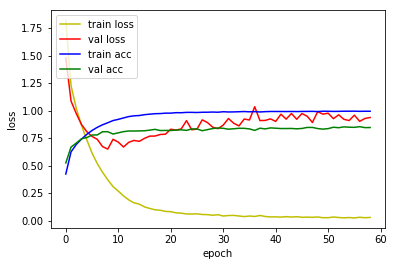

4815/4815 [==============================] - 4s 729us/sample - loss: 0.7751 - acc: 0.7688
Loss: 0.7750880870739867 Accuracy: 0.76884735

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8362 - acc: 0.4158
Epoch 00001: val_loss improved from inf to 1.29384, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_6_conv_checkpoint/001-1.2938.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 1.8362 - acc: 0.4158 - val_loss: 1.2938 - val_acc: 0.6122
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1730 - acc: 0.6404
Epoch 00002: val_loss improved from 1.29384 to 0.88927, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_6_conv_checkpoint/002-0.8893.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.1729 - acc: 0.6404 - val_loss: 0.8893 - val_acc: 0.7340
Epoch 3/500
36800/36805 [=====================

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9778
Epoch 00026: val_loss did not improve from 0.27197
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0696 - acc: 0.9778 - val_loss: 0.3320 - val_acc: 0.9236
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9800
Epoch 00027: val_loss did not improve from 0.27197
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0611 - acc: 0.9800 - val_loss: 0.3248 - val_acc: 0.9259
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9820
Epoch 00028: val_loss did not improve from 0.27197
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0576 - acc: 0.9820 - val_loss: 0.3592 - val_acc: 0.9201
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9839
Epoch 00029: val_loss did not improve from 0.27197
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9944
Epoch 00056: val_loss did not improve from 0.27197
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0209 - acc: 0.9944 - val_loss: 0.3649 - val_acc: 0.9322
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9937
Epoch 00057: val_loss did not improve from 0.27197
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0215 - acc: 0.9937 - val_loss: 0.3742 - val_acc: 0.9341
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9941
Epoch 00058: val_loss did not improve from 0.27197
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0204 - acc: 0.9941 - val_loss: 0.3672 - val_acc: 0.9369
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0185 - acc: 0.9945
Epoch 00059: val_loss did not improve from 0.27197
36805/36805 [===========

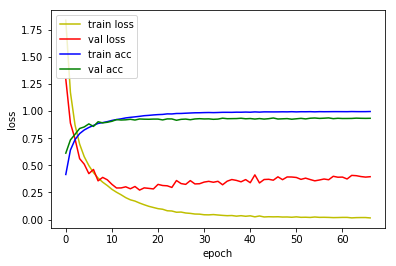

4815/4815 [==============================] - 4s 748us/sample - loss: 0.3458 - acc: 0.9032
Loss: 0.34576512503970575 Accuracy: 0.9032191

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8037 - acc: 0.4173
Epoch 00001: val_loss improved from inf to 1.07992, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_7_conv_checkpoint/001-1.0799.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 1.8036 - acc: 0.4173 - val_loss: 1.0799 - val_acc: 0.6699
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9713 - acc: 0.6950
Epoch 00002: val_loss improved from 1.07992 to 0.80365, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_7_conv_checkpoint/002-0.8036.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.9712 - acc: 0.6951 - val_loss: 0.8036 - val_acc: 0.7438
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0808 - acc: 0.9730
Epoch 00024: val_loss improved from 0.16292 to 0.15937, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_7_conv_checkpoint/024-0.1594.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0808 - acc: 0.9730 - val_loss: 0.1594 - val_acc: 0.9543
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0792 - acc: 0.9744
Epoch 00025: val_loss did not improve from 0.15937
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0792 - acc: 0.9744 - val_loss: 0.1790 - val_acc: 0.9504
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9758
Epoch 00026: val_loss did not improve from 0.15937
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0705 - acc: 0.9758 - val_loss: 0.1806 - val_acc: 0.9504
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9936
Epoch 00053: val_loss did not improve from 0.15937
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0205 - acc: 0.9935 - val_loss: 0.2815 - val_acc: 0.9362
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9929
Epoch 00054: val_loss did not improve from 0.15937
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0213 - acc: 0.9929 - val_loss: 0.2069 - val_acc: 0.9618
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9936
Epoch 00055: val_loss did not improve from 0.15937
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0195 - acc: 0.9936 - val_loss: 0.1992 - val_acc: 0.9578
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9943
Epoch 00056: val_loss did not improve from 0.15937
36805/36805 [========================

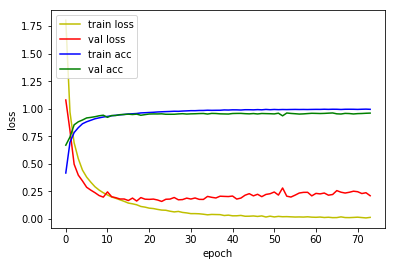

4815/4815 [==============================] - 4s 749us/sample - loss: 0.2272 - acc: 0.9379
Loss: 0.22724942879389629 Accuracy: 0.9379024

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8522 - acc: 0.3930
Epoch 00001: val_loss improved from inf to 0.96636, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_8_conv_checkpoint/001-0.9664.hdf5
36805/36805 [==============================] - 69s 2ms/sample - loss: 1.8521 - acc: 0.3931 - val_loss: 0.9664 - val_acc: 0.6834
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8870 - acc: 0.7082
Epoch 00002: val_loss improved from 0.96636 to 0.58412, saving model to model/checkpoint/1D_CNN_custom_multi_3_concat_ch_128_DO_8_conv_checkpoint/002-0.5841.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.8871 - acc: 0.7081 - val_loss: 0.5841 - val_acc: 0.8153
Epoch 3/500
36800/36805 [=====================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9805
Epoch 00025: val_loss did not improve from 0.13306
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0585 - acc: 0.9805 - val_loss: 0.1856 - val_acc: 0.9543
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9807
Epoch 00026: val_loss did not improve from 0.13306
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0575 - acc: 0.9807 - val_loss: 0.1573 - val_acc: 0.9576
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0477 - acc: 0.9836
Epoch 00027: val_loss did not improve from 0.13306
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0477 - acc: 0.9836 - val_loss: 0.1651 - val_acc: 0.9564
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9845
Epoch 00028: val_loss did not improve from 0.13306
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0170 - acc: 0.9946
Epoch 00055: val_loss did not improve from 0.13306
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0170 - acc: 0.9946 - val_loss: 0.2285 - val_acc: 0.9616
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9944
Epoch 00056: val_loss did not improve from 0.13306
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0181 - acc: 0.9944 - val_loss: 0.1869 - val_acc: 0.9639
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9958
Epoch 00057: val_loss did not improve from 0.13306
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0127 - acc: 0.9958 - val_loss: 0.1966 - val_acc: 0.9641
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9954
Epoch 00058: val_loss did not improve from 0.13306
36805/36805 [===========

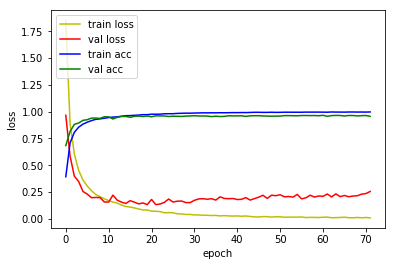

4815/4815 [==============================] - 4s 774us/sample - loss: 0.1851 - acc: 0.9456
Loss: 0.18510139149885435 Accuracy: 0.9455867



In [10]:
base = '1D_CNN_custom_multi_3_concat_ch_128_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_3_concat_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_3_concat_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
________________________________________________________

4815/4815 [==============================] - 4s 765us/sample - loss: 1.1330 - acc: 0.6584
Loss: 1.1330423045628786 Accuracy: 0.6583593

1D_CNN_custom_multi_3_concat_ch_128_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 128)   0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (Ma

4815/4815 [==============================] - 4s 769us/sample - loss: 0.3458 - acc: 0.9032
Loss: 0.34576512503970575 Accuracy: 0.9032191

1D_CNN_custom_multi_3_concat_ch_128_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 128)   0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (M

4815/4815 [==============================] - 4s 829us/sample - loss: 0.1851 - acc: 0.9456
Loss: 0.18510139149885435 Accuracy: 0.9455867


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_3_concat_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
________________________________________________________

4815/4815 [==============================] - 4s 807us/sample - loss: 2.0547 - acc: 0.7032
Loss: 2.054721259006211 Accuracy: 0.7032191

1D_CNN_custom_multi_3_concat_ch_128_DO_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 128)   768         input_9[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 16000, 128)   0           conv1d_40[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_40 (Max

4815/4815 [==============================] - 4s 852us/sample - loss: 0.4799 - acc: 0.9121
Loss: 0.4798922586104874 Accuracy: 0.91214955

1D_CNN_custom_multi_3_concat_ch_128_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 128)   768         input_11[0][0]                   
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 16000, 128)   0           conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_51 (M

4815/4815 [==============================] - 4s 837us/sample - loss: 0.3158 - acc: 0.9479
Loss: 0.3158362437357291 Accuracy: 0.9478712
